# ReadMe

**INTRODUCTION**

This Model has been created in order to **cluster unsupervised data** during my internship at BMW. It uses an Doc2Vec Model as the core of this notebook, to obtain numerical representation of the text data, so called **DocEmbeddings**.

This Notebook can be splitted into the following sections:
- **Load Data**: Load and clean the data (dropping duplicates, eliminating outliers, filtering, ...); Also allows sentence splitting if the data is a whole paragraph
- **Tokenize Data**: Tokenize the Data using the 'MyTokenizer' Class. Tokens serve as the input for our Doc2Vec Model and can be interpreted as a cleaned version of a word
- **Create DocEmbeddings**: Create numerical representations of our text data, which we then use for dimensionality reduction and clustering
- **Reduce Dimensionality**: DocEmbeddings have a default shape of 200 dimensions, which we cannot visualize and correctly work with. Thats why we use TSNE in order to reduce the dimensions to two dimensions while preservering the overall structure of the data
- **Clustering and Visualization**: We then use the two dimensional TSNE data to cluster and visualize it via bokeh
- **Additional Function Sections**: We can visualize n-grams to see which keywords get captured by each cluster (Explainability AI). We can also find similar documents given an arbitrary input doc. We can also dive deeper into a certain cluster using the 'draw_subcluster' function. Lastly we can use the _OpenAI Text Summarization_ to generate a summarization of each cluster.

The 'Backend' has been written in the _custom_classes_ directory as classes each (OOP paradigm). This ensure that the code can be changed easily without losing the overview. In general, this notebook serves as a console, where we only look at the results and define the hyperparameters for each section. Hyperparameters are written in capitalized letters and can be defined arbitrary.

**OBJECTIVES** 🎯

- Allows to **automatically read and understand the data** without reading all feedbacks manually
- Allows to **find similar feedbacks** of a given input text by using the cosine similarity
- Allows to **summarize all feedbacks** of a given cluster by using OpenAI Text Summarization
- Allows to **easily label the data**

**POTENTIAL USE CASES**
- Explore new, unknown data to understand what it is about (i.e. app store feedback)
- Challenge and validate existing classes in a supervised classification approach
- Identify new topics in “global other” bucket of a supervised classification approach
- Drill-down into a specific subset of data (i.e. “seat/ defects” à cluster + summarize)

**POINTS TO IMPROVE / POSSIBLE EXTENSIONS**
- Improve our Doc2Vec Model by training it with more data (> 1 Million). Current master model is trained on ~850k cleaned and tokenized **sentences**
- Fine tuning is a long and difficult process and each use cases needs different hyperparameters
- Impact Integration
- Challenge Doc2Vec approach by a transformer approach (e.g. BERT)
_______
_Author: Alessio Negrini ([LinkedIn](https://www.linkedin.com/in/alessio-negrini-9a7847230/)), 23rd March 2022_

In [1]:
%%capture
!pip install gensim
!pip install cmake==3.18.4
!pip install MulticoreTSNE
!pip install umap-learn

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%capture
from custom_classes.D2V_LoadAndPreprocesser import LoadAndPreprocessor
from custom_classes.D2V_MyTokenizer import MyTokenizer
from custom_classes.D2V_MyDoc2Vec import MyDoc2Vec
from custom_classes.D2V_MyDimensionalityReducer import MyDimensionalityReducer
from custom_classes.D2V_MyClustering import MyClustering
from custom_classes.D2V_MyVisualizer import MyVisualizer

# Load Data

Load the data into the pipeline. Make sure that the data is all stacked, i.e. one big data set and that you defined the **TARGET_COLUMN** as the name of the column you want to analyze (usually sentences, or whole custumer_feedbacks).

Requirements:
- **PATH_TO_DATA**: Defines the path to the current data. The data is stacked, i.e. its one big dataset
- **TARGET_COLUMN**: Defines the column we want to analyze. Usually its a column filled with sentences; can also be whole customer feedbacks, but a sentence split might be more useful
- **sep**: Define what seperates the data (default sep=',').

Uncomment the **'do_sentence_split'** function, if there hasn't been a sentence split before.

For the loading and preprocessing we use the **LoadAndPreprocessor** class, that expects the path to the data and a target column.

In [4]:
# Define column you want to analyze; should be a sentence column, i.e. sentence splitted data
TARGET_COLUMN = "content"

# Apple CarPlay Use-Case:
PATH_TO_DATA = "data/tinder_google_play_reviews.csv"

# Load Data by defining the data path and the target column
loadandpreprocessor = LoadAndPreprocessor(PATH_TO_DATA=PATH_TO_DATA, TARGET_COLUMN=TARGET_COLUMN, sep=",", type="csv")

# Take sample (if data size is too high). Notebook will then use sample matrix instead of original matrix
loadandpreprocessor.take_sample_matrix(n=10000)

###################################################################################################
# Uncomment this section, to do a sentence split on the TARGET_COLUMN
loadandpreprocessor.do_sentence_split(column = TARGET_COLUMN, set_to_target_column = True, name_of_new_sentence_column = "sentence")
TARGET_COLUMN = loadandpreprocessor.get_target_column()
###################################################################################################

# Show preview of the original dataframe before any preprocessing happens
#master = loadandpreprocessor.get_master_df()
#master.head(5)

Data in data/tinder_google_play_reviews.csv has been sucessfully read.
Original shape of DataFrame: (531174, 10)
Target column: content
Sample of size 10000 has been taken instead.


## Pre filtering (optional)

⚠️ **Attention**: Define your filter within the **filter_master()** function in the class **"D2V_LoadAndPreprocessor"**

In [5]:
# Call filter on object
loadandpreprocessor.filter_master(cols_to_drop = ["userImage", "userName", "replyContent", "thumbsUpCount", "reviewCreatedVersion", "at", "repliedAt"])
# Get master df
master = loadandpreprocessor.get_master_df()
print(f"Shape: {master.shape}")
master.head(3)

Shape: (16655, 4)


,reviewId,content,score,sentence
0,gp:AOqpTOGu5aL540u7X8zSG1aQSXjFJWkXUzmnGlV1iEh...,Says I am not connected to the Internet,1,Says I am not connected to the Internet
1,gp:AOqpTOFq01nkZn_GYZAna8syCRwfXprsQ2G2hYJbwPd...,Love it,5,Love it
2,gp:AOqpTOGPVKnvgVPukeoyVu4j8tyH4bNHPGnfG4BCEh9...,Some succeed. It's easy,4,Some succeed.


# Preprocess Data

Define the interval $I = [a, b]$ in the **'cut_head_and_tail()'**-function, so that all data where its sentence length is not in $I$ gets removed

Table Dimensions after dropping duplicates on 'sentence' column: (14526, 4)
Removed rows by dropping duplicates: 2129 (12.78%)


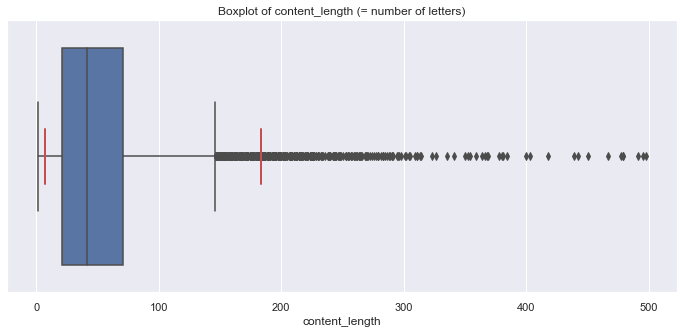

count    14526.000000
mean        53.034765
std         46.472579
min          1.000000
25%         21.000000
50%         41.000000
75%         71.000000
max        498.000000
Name: content_length, dtype: float64
__________________________________________________________________________________________
Lower Bound is 7.0 (5-percentile), Upper Bound is 183.0 (98-percentile) -- see red vlines
Master Shape before content length removal: (14526, 5)
Master Shape after content length removal: (13605, 5)
Removed rows: 921 (6.34%)
__________________________________________________________________________________________


In [6]:
# Drop Duplicates
loadandpreprocessor.clean_data()

# Define interval bounds
A_PERCENTILE = 5
B_PERCENTILE = 98

# Remove all data where length(sentence) is not in [a_percentile, b_percentile]
loadandpreprocessor.cut_head_and_tail(a_percentile=A_PERCENTILE, b_percentile=B_PERCENTILE)

# Tokenize Data

All data in the TARGET_COLUMN (usually sentences) will be transformed into tokens and serve as a input for our Doc2Vec Model. 

All Tokens will be cleaned and lemmatized, tokens with length of 0 removed, stopwords removed, etc. (see **clean_text()** function in MyTokenizer class). 

The tokens then **serve as the input** for out Doc2Vec Model.

In [7]:
# Return preprocessed master df
master = loadandpreprocessor.get_master_df()

# Define custom stopwords for the tokenization process
custom_stopwords = ['tinder']

# Instantiate MyTokenizer Class and feed it with preprocessed master_df
mytokenizer = MyTokenizer(master=master, TARGET_COLUMN=TARGET_COLUMN, custom_stopwords=custom_stopwords)

## Find TFIDF Stopwords

Find context based tfidf stopwords that will be added to the final custom stopwords list. All tokens that are stopwords, will be removed before the data gets fed into the doc2vec model. Setting the **print_interval** parameter to **True** will print multiple tfidf stopwords, that will help you choosing the best parameter: Choose the **max_docfreq** parameter according to the best result.

- **max_docfreq** default 0.2
- **print_intervall** default false
- **lower_max_df** default 0.05: lower bound of the interval
- **upper_max_df** default 0.5: upper bound of the interval

In [8]:
# Define Hyperparams
# All words with df(word) > MAX_DOCFREQ will be marked as a stopword
MAX_DOCFREQ = 0.05

mytokenizer.get_tfidf_stopwords(max_docfreq = MAX_DOCFREQ, print_interval = True, lower_max_df = 0.05, upper_max_df = 0.25)

Identified Stop Words through TFIDF (max_df = 0.25):
[]
________________________________________________________________________________________________________________________
Identified Stop Words through TFIDF (max_df = 0.2):
[]
________________________________________________________________________________________________________________________
Identified Stop Words through TFIDF (max_df = 0.15):
['app']
________________________________________________________________________________________________________________________
Identified Stop Words through TFIDF (max_df = 0.1):
['app']
________________________________________________________________________________________________________________________
Identified Stop Words through TFIDF (max_df = 0.05):
['people', 'app', 'tinder']
________________________________________________________________________________________________________________________
Attention: print_interval was set to True. Taking the tfidf stopwords yielded by s

## Create Stopwords List

You can define words in **remove_stopwords:list** that you want to remove in the final stopwords list.

In [9]:
# Manually enter which stopwords should not be treated as stopwords
remove_stopwords = []
mytokenizer.create_stopword_list(stopwords_to_remove = remove_stopwords)

# Get stopwords for later processing
STOPWORDS_FINAL = mytokenizer.get_final_stopwords_list()

________________________________________________________________________________________________________________________
TFIDF stopwords:
['people', 'app', 'tinder']

Custom stopwords:
['tinder']

Stopwords to remove:
[]

Review of all stopwords:
['don', 'myself', 'for', 'which', 'against', 'y', 'whom', 'were', 'here', 'when', 'ma', 'to', "wouldn't", 'few', 'then', 'yourselves', 'because', 'theirs', 'weren', 'about', 'he', 'hadn', 'doesn', 'won', 'again', "you'd", 'isn', 'very', 'over', 'o', 'mightn', "that'll", 'himself', 'can', 'was', 're', "you'll", 'while', 'same', 'than', 'during', 'these', 'needn', 'this', 'people', 'too', 'the', "haven't", 'each', "isn't", 'mustn', 'through', "wasn't", 'is', 'wouldn', 'shouldn', 'off', 'such', "couldn't", 'and', 'only', "you're", "hasn't", "won't", "weren't", 'll', 'both', 'aren', 'it', 'been', 'did', 'being', 'nor', 'more', 'his', 'herself', "shouldn't", 'i', 'further', 'your', "should've", 'from', 'ain', 'doing', 've', "don't", 'have', 'my', '

## Create Tokens

Tokens will be produced after the cleaning process defined in **mytokenizer.clean_text()**. The tokens will be appended to the master dataframe, which can be returned by calling the **get_master_df** function.

In [10]:
# Create tokens; Define minimum length of a token (default: 1)
mytokenizer.create_tokens(min_length_of_a_token = 1)
master = mytokenizer.get_master_df()

In [11]:
# Preview of the cleaned Data: The data now serves as the input of our Doc2Vec Model
master.head(3)

,reviewId,content,score,sentence,content_length,tokens
0,gp:AOqpTOGu5aL540u7X8zSG1aQSXjFJWkXUzmnGlV1iEh...,Says I am not connected to the Internet,1,Says I am not connected to the Internet,39,"[say, connected, internet]"
1,gp:AOqpTOFq01nkZn_GYZAna8syCRwfXprsQ2G2hYJbwPd...,Love it,5,Love it,7,[love]
2,gp:AOqpTOGPVKnvgVPukeoyVu4j8tyH4bNHPGnfG4BCEh9...,Some succeed. It's easy,4,Some succeed.,13,[succeed]


# Create DocEmbeddings using Doc2Vec

This section is about the __core__ of our model: Creating good vector representations of text, i.e. __DocEmbeddings__.

⚠️ **Attention**: Either call the 'use_pretrained_model' method, **or** the 'create_new_model' method on the _MyDoc2Vec_ object (default: 'use_pretrained_model').

In [12]:
# Instantiate MyDoc2Vec class and provide the master df
mydoc2vec = MyDoc2Vec(master = master, name_of_token_column = "tokens", target_column = TARGET_COLUMN)

# Get master df with DocEmbedding column by calling the 'use_pretrained_model' function
master = mydoc2vec.use_pretrained_model(path_to_pretrained_model = "tinder_model_sentences", allow_finetune = True, train_epochs = 50, epochs_of_infering_vectors = 300)

# ALTERNATIVE: Create new doc2vec model by calling the 'create_new_model' function
#master = mydoc2vec.create_new_model(vector_size = 200, epochs=20, seed=1997)
#mydoc2vec.save_model(file_name="tinder_model_senteces")

DocEmbeddings created in 179.83s


In [13]:
master.head(3)

,reviewId,content,score,sentence,content_length,tokens,vectorized_docs
0,gp:AOqpTOGu5aL540u7X8zSG1aQSXjFJWkXUzmnGlV1iEh...,Says I am not connected to the Internet,1,Says I am not connected to the Internet,39,"[say, connected, internet]","[0.21179919, -0.10342016, -0.06202426, -0.0260..."
1,gp:AOqpTOFq01nkZn_GYZAna8syCRwfXprsQ2G2hYJbwPd...,Love it,5,Love it,7,[love],"[0.037008323, -0.11645697, 0.017516287, 0.0467..."
2,gp:AOqpTOGPVKnvgVPukeoyVu4j8tyH4bNHPGnfG4BCEh9...,Some succeed. It's easy,4,Some succeed.,13,[succeed],"[-0.15362594, -0.068870515, -0.14127679, -0.00..."


## Get Feature Matrix X

The feature matrix $X$ is the matrix form of the **vectorized_docs** column in master. We use $X$ for dimensionality reduction and clustering.

In [14]:
# Get Feature Matrix X for Dimensionality Reduction and Clustering
X = mydoc2vec.get_feature_matrix()

X.head(5)

Shape of Feature Matrix X: (13561, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.211799,-0.103420,-0.062024,-0.026022,-0.058496,-0.116135,-0.011364,0.104153,0.113325,-0.130667,...,0.285934,-0.176590,-0.071110,-0.047709,-0.147350,0.013216,0.064277,-0.028131,0.092098,0.094280
1,0.037008,-0.116457,0.017516,0.046787,0.003251,-0.098002,-0.127281,0.101312,0.168920,0.012008,...,0.047545,-0.073743,-0.014631,-0.092199,-0.103175,-0.042894,0.016358,0.055847,0.113220,0.061599
2,-0.153626,-0.068871,-0.141277,-0.005450,0.051209,-0.063038,-0.099653,0.251806,-0.143685,0.160792,...,0.170713,0.078212,0.014844,-0.251374,0.093550,-0.231788,-0.229823,0.014606,0.133032,0.113603
3,-0.017690,-0.148262,0.098561,0.093705,0.047389,-0.109200,-0.059688,0.102459,0.068368,-0.101035,...,0.054906,-0.050620,0.022979,0.007206,0.046521,0.088306,0.023934,0.055386,0.086035,0.188340
4,0.073970,-0.154782,0.025063,0.066186,0.180444,-0.021519,0.077836,-0.025085,0.234711,0.106215,...,-0.031156,0.042923,-0.003257,-0.005597,0.100859,0.202936,0.002174,-0.095870,-0.094611,-0.034353


# Reduce Dimensionality of X

There are multiple algorithm to reduce dimensions of high dimensional data. This notebook allows the following algorithms specified in "D2V_MyDimensionalityReducer":

$$A = \{TSNE,\; PCA,\; UMAP\}$$

We need a dimensionality reduction algorithm in order to visualize the data, since we can only plot up to three dimensions. It is recommended to use [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) since it performed best in recent runs. To run the specified algorithm, use the **'apply_x()'** function with **x** $\in A$

For TSNE we use MultiCore TSNE, which is a faster and better implementation of the algorithm. To learn more about it, see [here](https://github.com/DmitryUlyanov/Multicore-TSNE). Check out this [youtube video](https://www.youtube.com/watch?v=NEaUSP4YerM) to learn how TSNE works.

In [15]:
# Instantiate Class
mydimensionalityreducer = MyDimensionalityReducer(feature_matrix = X)

## Using TSNE

In [16]:
# Define Hyperparams
LEARNING_RATE = 200 # (default: 200)
# If data row size is low (<10000 rows), set perplexity to [5, 20), if high (>= 10000 rows) [20, 50]
PERPLEXITY = 30 # (default: 30), If low, captures local structure of data; If high, captures global structure

# Apply TSNE
X_TSNE = mydimensionalityreducer.apply_tsne(n_components = 2, learning_rate = LEARNING_RATE, perplexity = PERPLEXITY)
X_TSNE.head(5)

Shape of X_transformed_df: (13561, 2)
TSNE was applied in 95.5s


,TC1,TC2
0,10.370150,13.977084
1,17.447605,-37.172298
2,-82.670113,8.877113
3,21.178291,-17.928568
4,-9.984453,-49.637005


## Using PCA

In [17]:
# Apply PCA
#X_PCA = mydimensionalityreducer.apply_pca(n_components = 5)
#X_PCA.head(5)

## Using UMAP

In [18]:
# Apply UMAP
#X_UMAP = mydimensionalityreducer.apply_umap(n_neighbors = 10)
#X_UMAP.head(5)

# Clustering and Visualization

Define the hyperparameter **n_clusters_x** for x in {TSNE, PCA, UMAP}.

As a help, use the elbow_method in order to print the decrease of the Inertia (WCSS).The Inertia of cluster $k$ can be describe as a **mean of density** and is defined as: $$ Inertia(k) = \sum_{i=1}^{n} (x_{i,k} - C_k)^2$$

with $x_{i,k}$ being a data object of cluster k, $C_k$ being the centroid of cluster $k$.

The 'elbow' in the plot, describes the point where adding new clusters/centroids (i.e. increasing n_clusters) would not significantly decrease the sum of all inertia. Therefore, adding a new cluster would not make that much sense, since we already have dense clusters (atleast to a certain degree).
For a good tutorial and understanding, see this [towardsdatascience blog entry](https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819).

In [19]:
# Instantiate clustering class
myclustering_TSNE = MyClustering(X_transformed_df = X_TSNE)
#myclustering_PCA = MyClustering(X_transformed_df = X_PCA)
#myclustering_UMAP = MyClustering(X_transformed_df = X_UMAP)

## TSNE Clustering

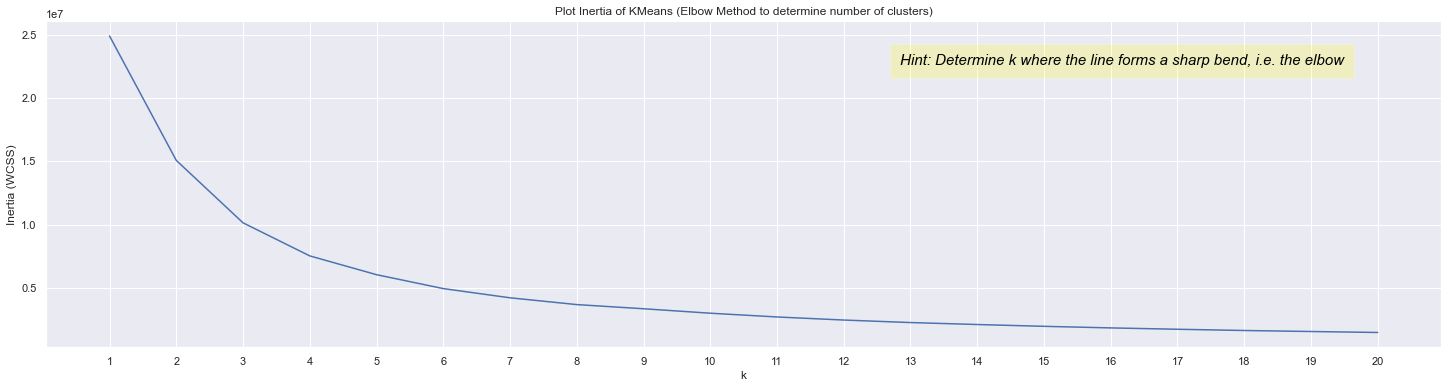

Cluster and its number of occurence: {29: 774, 12: 557, 5: 538, 24: 534, 10: 528, 27: 521, 13: 520, 22: 517, 0: 515, 2: 510, 4: 502, 11: 500, 3: 496, 26: 465, 15: 456, 19: 450, 28: 443, 23: 431, 7: 429, 18: 420, 9: 419, 20: 412, 21: 386, 16: 365, 1: 339, 14: 336, 6: 326, 8: 318, 17: 303, 25: 251}


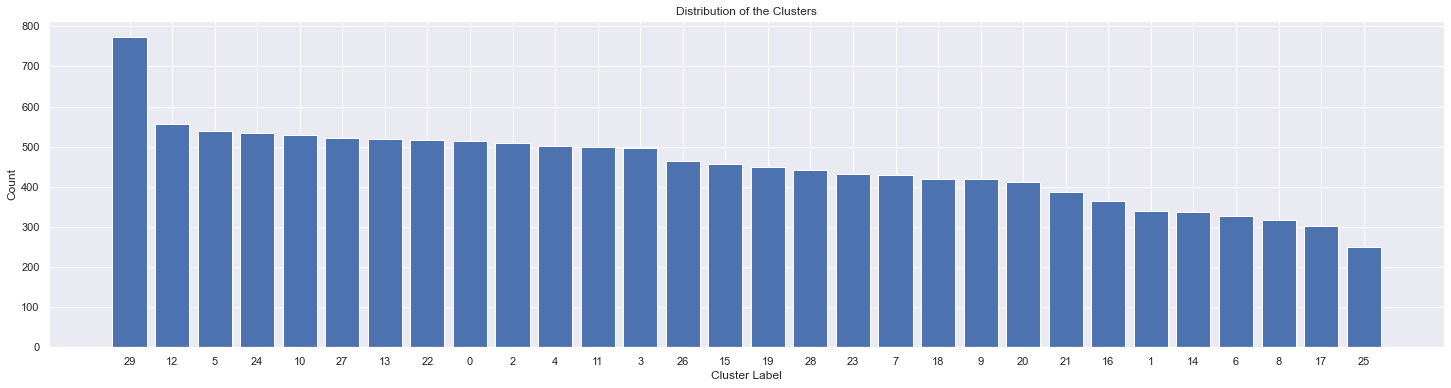

Loading BokehJS ...

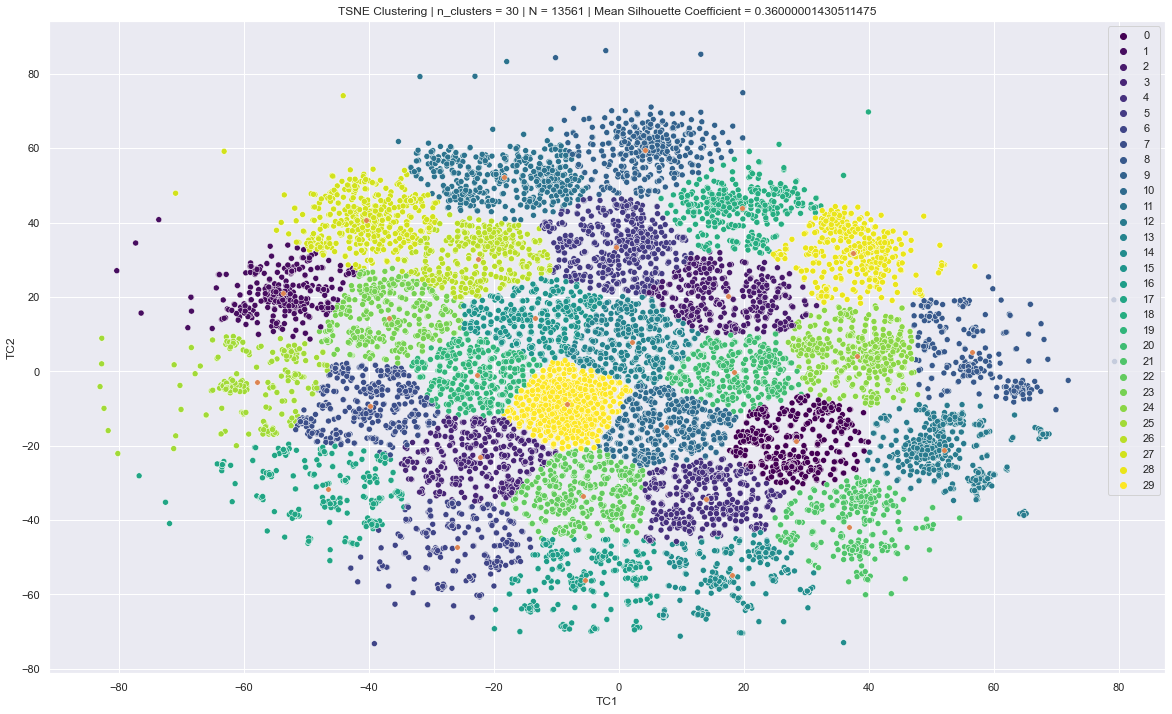

In [20]:
# Hyperparams
N_CLUSTERS_TSNE = 30
MAX_K_ELBOW_METHOD = 20 # default: 20

# Apply Clustering on TSNE DataFrame
myclustering_TSNE.plot_elbow_method(max_k = MAX_K_ELBOW_METHOD)
X_transformed_df_TSNE = myclustering_TSNE.apply_kmeans(n_clusters = N_CLUSTERS_TSNE)
myclustering_TSNE.plot_distribution_of_clusters()

# Append master information to X_transformed_df for visualization (tooltips)
X_transformed_df_TSNE[TARGET_COLUMN] = master[TARGET_COLUMN]
X_transformed_df_TSNE["tokens"] = master["tokens"]
master["kmeans_cluster"] = X_transformed_df_TSNE["kmeans_cluster"]
    
# Instantiate visualization class and call plot
myvisualizer_TSNE = MyVisualizer(X_transformed_df = X_transformed_df_TSNE, 
                                  n_clusters = N_CLUSTERS_TSNE, 
                                  kind = "TSNE", 
                                  target_column = TARGET_COLUMN, 
                                  centroids = myclustering_TSNE.centroids,
                                  silhouette_score = myclustering_TSNE.get_silhouette_score())

# Use .plot() for bokeh visualization
#myvisualizer_TSNE.plot()

myvisualizer_TSNE.plot_seaborn()

## PCA Clustering

In [21]:
# # Hyperparams
# N_CLUSTERS_PCA = 10

# # Apply Clustering on TSNE DataFrame
# myclustering_PCA.plot_elbow_method(max_k = 20)
# X_transformed_df_PCA = myclustering_PCA.apply_kmeans(n_clusters = N_CLUSTERS_PCA)
# myclustering_PCA.plot_distribution_of_clusters()

# # Append master information to the X_transformed_df for visualization (tooltips)
# X_transformed_df_PCA[TARGET_COLUMN] = master[TARGET_COLUMN]
# X_transformed_df_PCA["tokens"] = master["tokens"]
# master["kmeans_cluster"] = X_transformed_df_PCA["kmeans_cluster"]
# X_transformed_df_PCA["detailed_category_cut"] = master["detailed_category_cut"]

# # Instantiate visualization class and call plot
# myvisualizer_PCA = MyVisualizer(X_transformed_df = X_transformed_df_PCA, 
#                                 n_clusters = N_CLUSTERS_PCA, kind="PCA", 
#                                 target_column=TARGET_COLUMN, centroids=myclustering_PCA.centroids)

# myvisualizer_PCA.plot()

# print(f"Mean Silhouette Coefficient = {myclustering_PCA.get_silhouette_score()}")

## UMAP Clustering

In [22]:
# # Hyperparams
# N_CLUSTERS_UMAP = 10

# # Apply Clustering on TSNE DataFrame
# myclustering_UMAP.plot_elbow_method(max_k = 20)
# X_transformed_df_UMAP = myclustering_UMAP.apply_kmeans(n_clusters = N_CLUSTERS_UMAP)
# myclustering_UMAP.plot_distribution_of_clusters()

# # Append master information to the X_transformed_df for visualization (tooltips)
# X_transformed_df_UMAP[TARGET_COLUMN] = master[TARGET_COLUMN]
# X_transformed_df_UMAP["tokens"] = master["tokens"]
# master["kmeans_cluster"] = X_transformed_df_UMAP["kmeans_cluster"]
# #X_transformed_df_UMAP["detailed_category_cut"] = master["detailed_category_cut"]

# # Instantiate visualization class and call plot
# myvisualizer_UMAP = MyVisualizer(X_transformed_df = X_transformed_df_UMAP, 
#                                  n_clusters = N_CLUSTERS_UMAP, kind="UMAP", 
#                                  target_column=TARGET_COLUMN, centroids=myclustering_UMAP.centroids)
# myvisualizer_UMAP.plot()

# print(f"Mean Silhouette Coefficient = {myclustering_UMAP.get_silhouette_score()}")

_____________

# + Function: Visualize n-grams

In this section we try to explain why certain clusters were created (**Explainability AI**).

We use a naive approach and count all tokens occurences in each cluster. We can count the keywords, the bigrams or the trigrams (specified in the variable **N_GRAMS**).

In [23]:
from custom_classes.D2V_MyKeywordsAnalyzer import MyKeywordsAnalyzer
from bokeh.palettes import viridis 

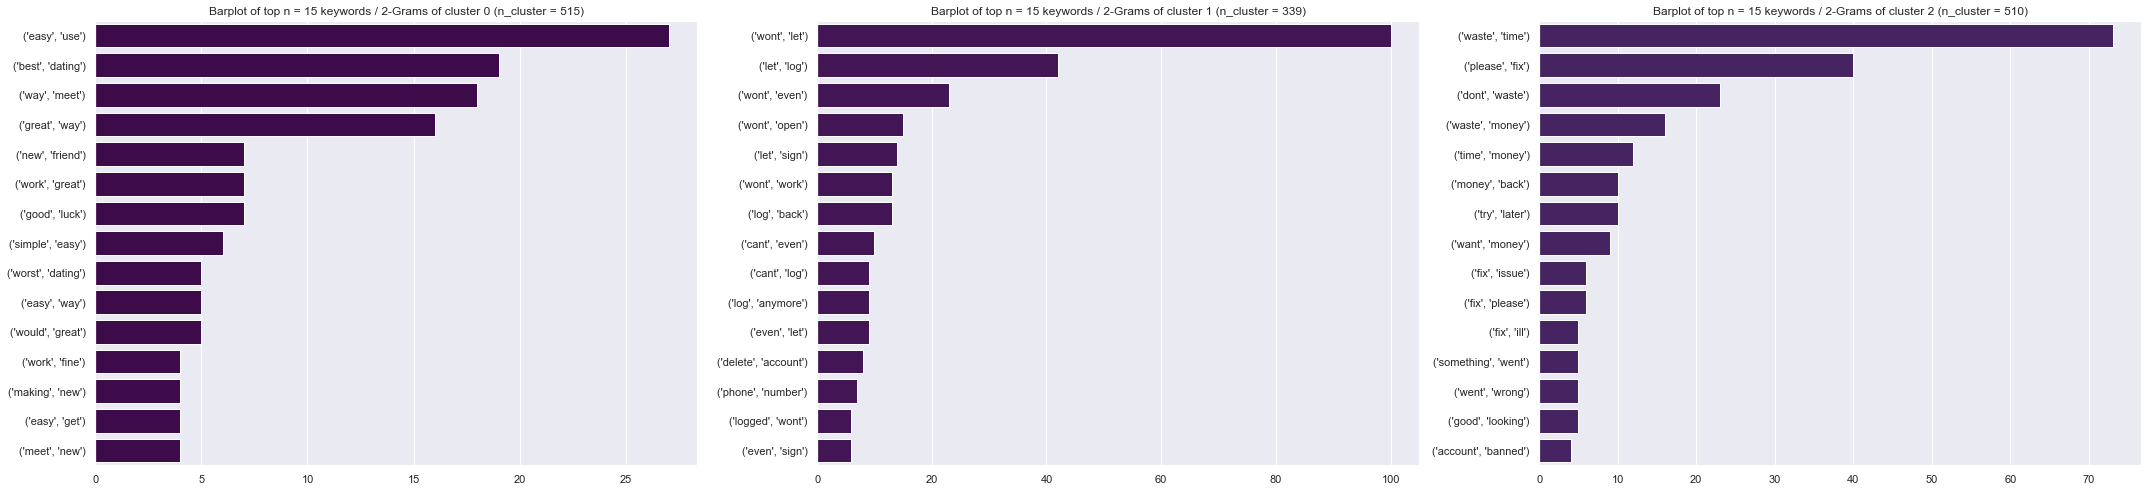

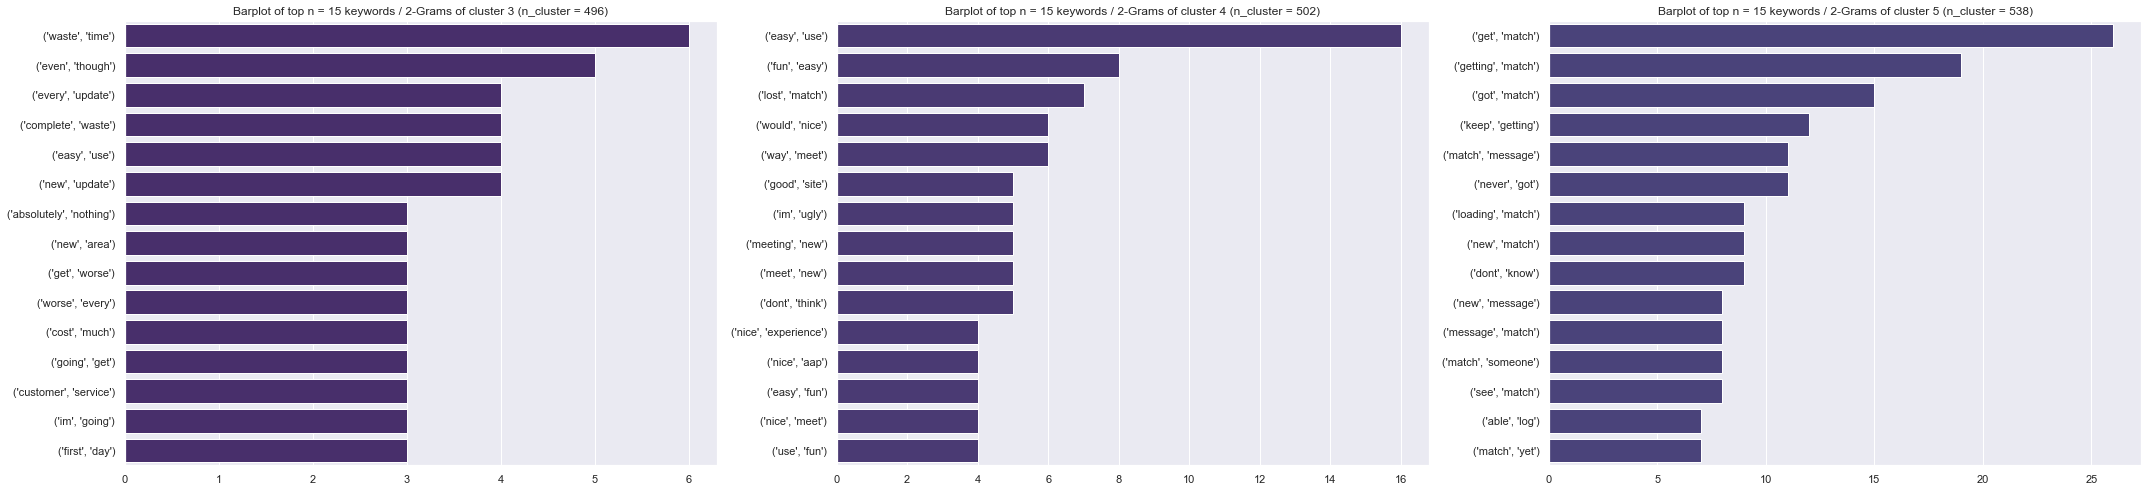

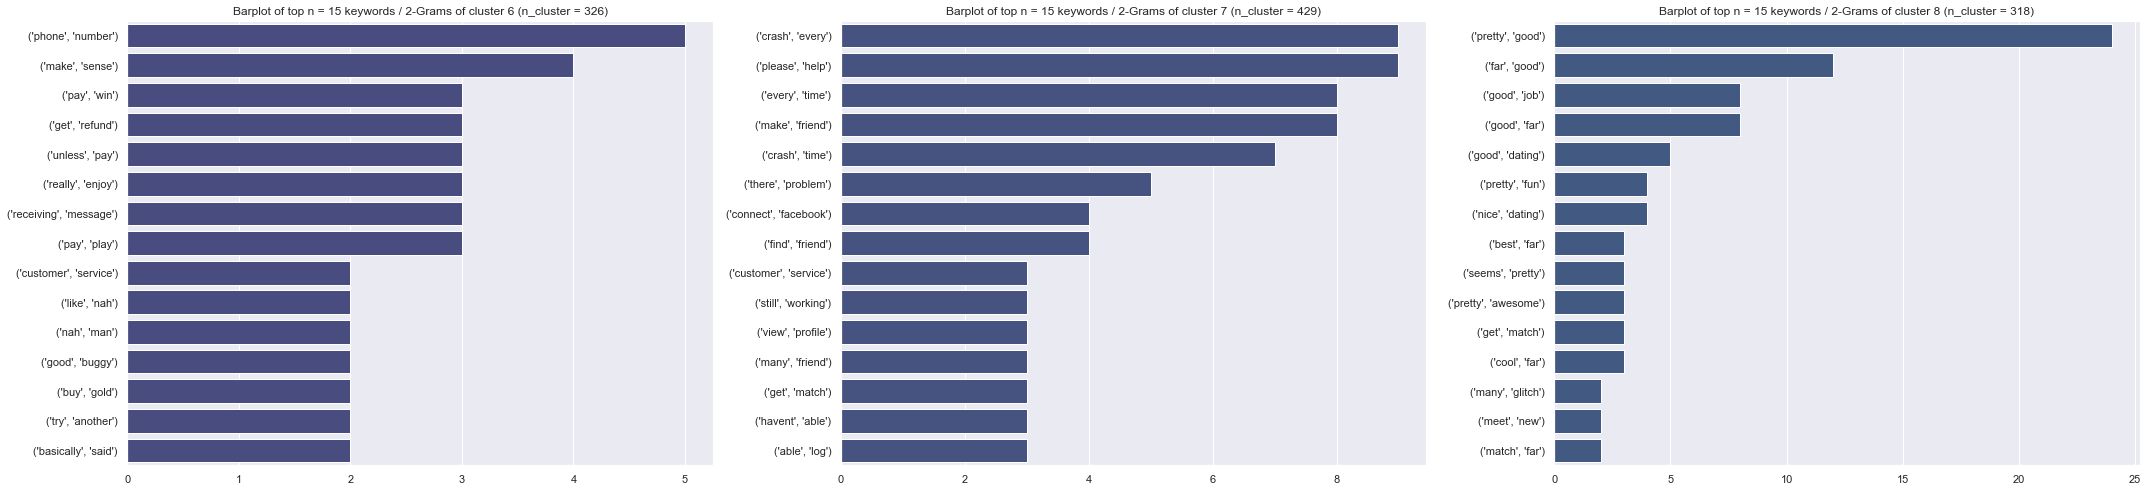

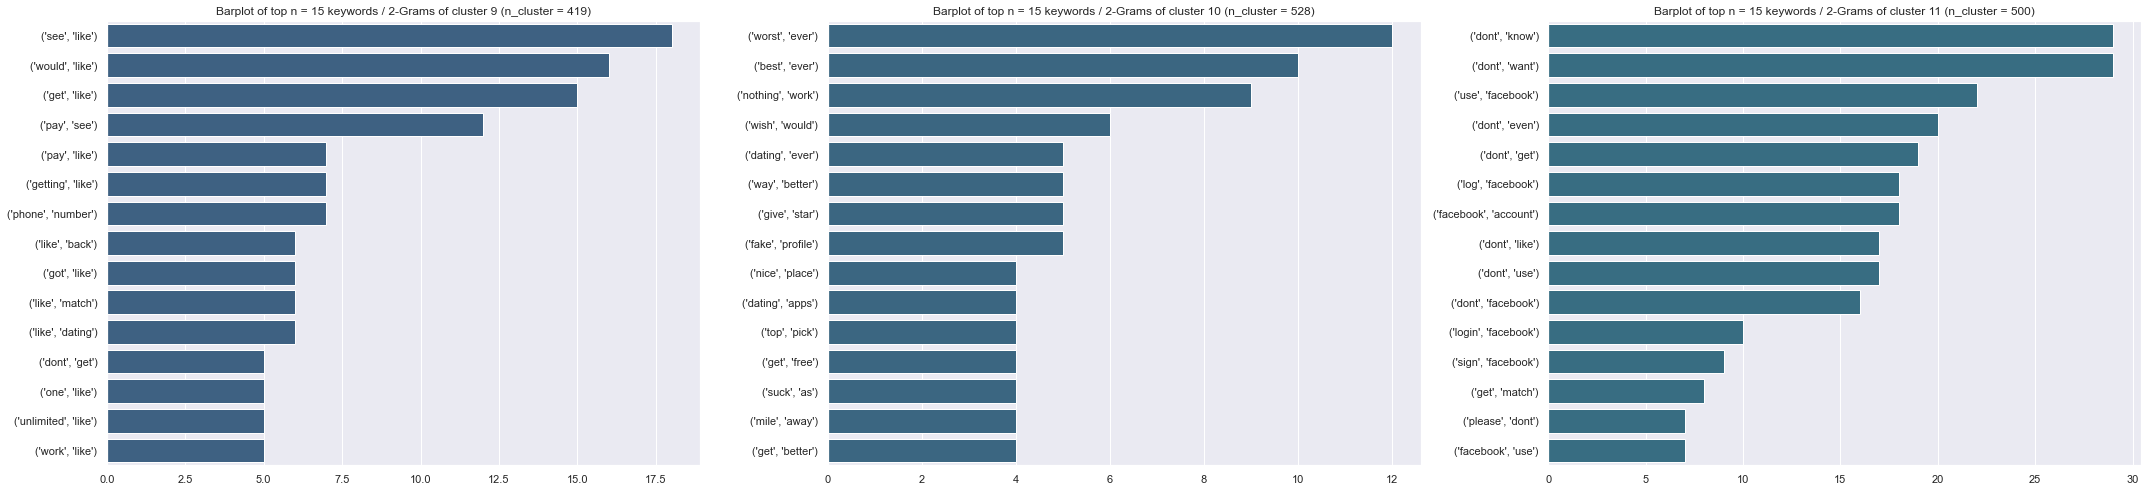

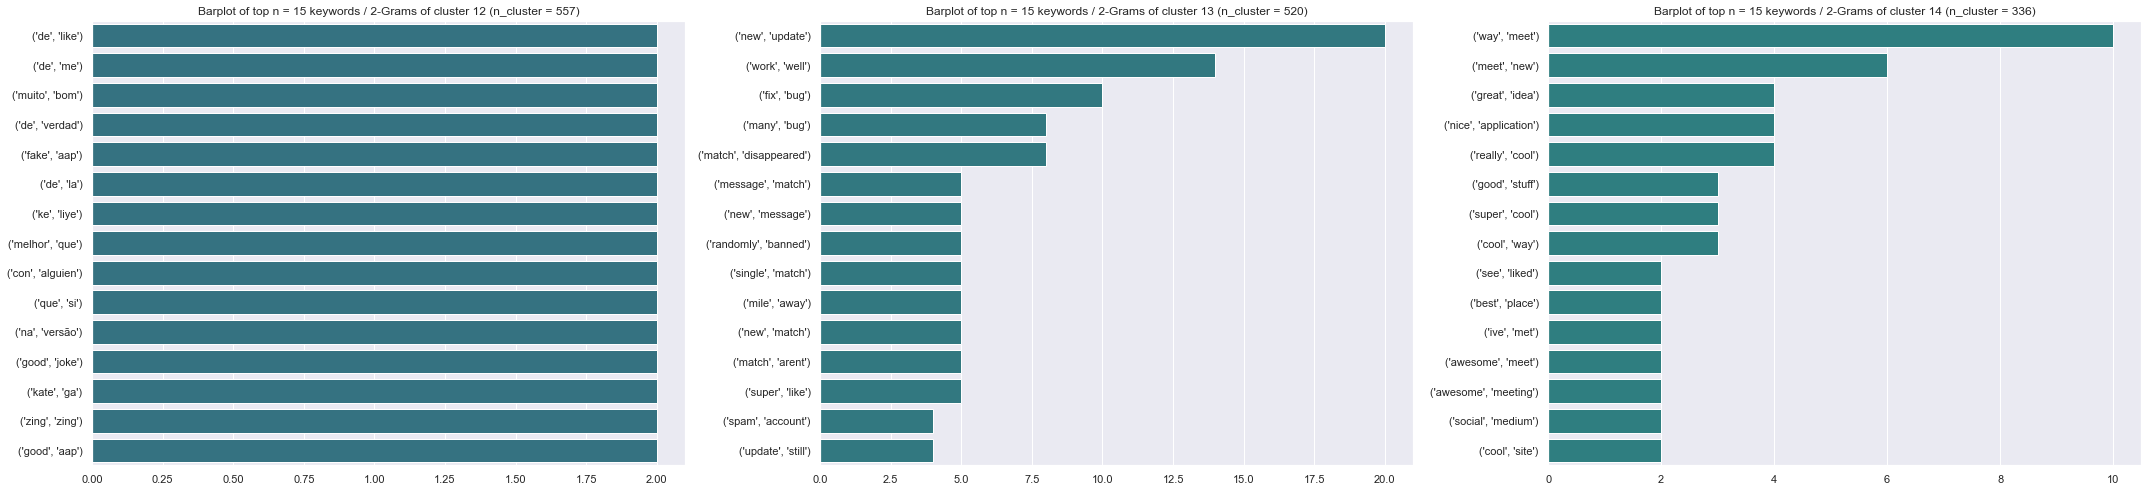

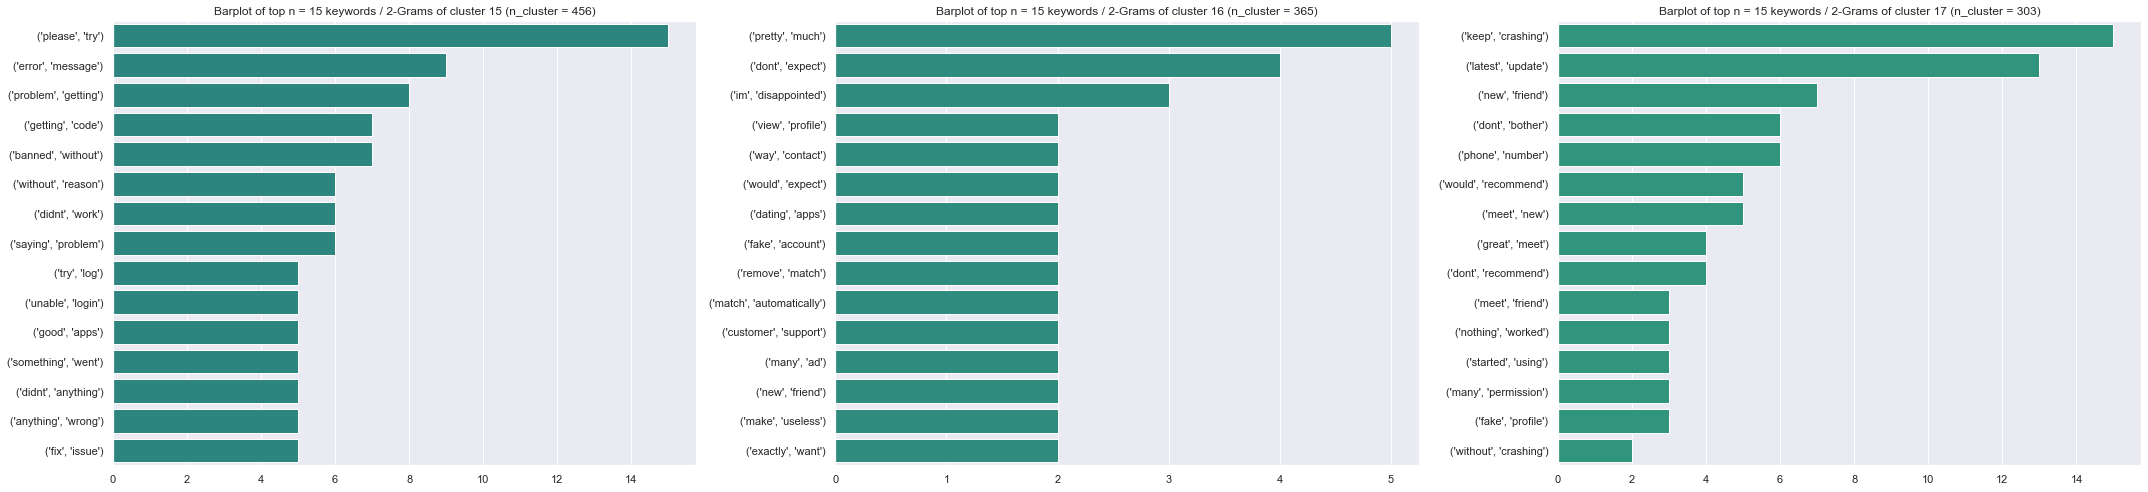

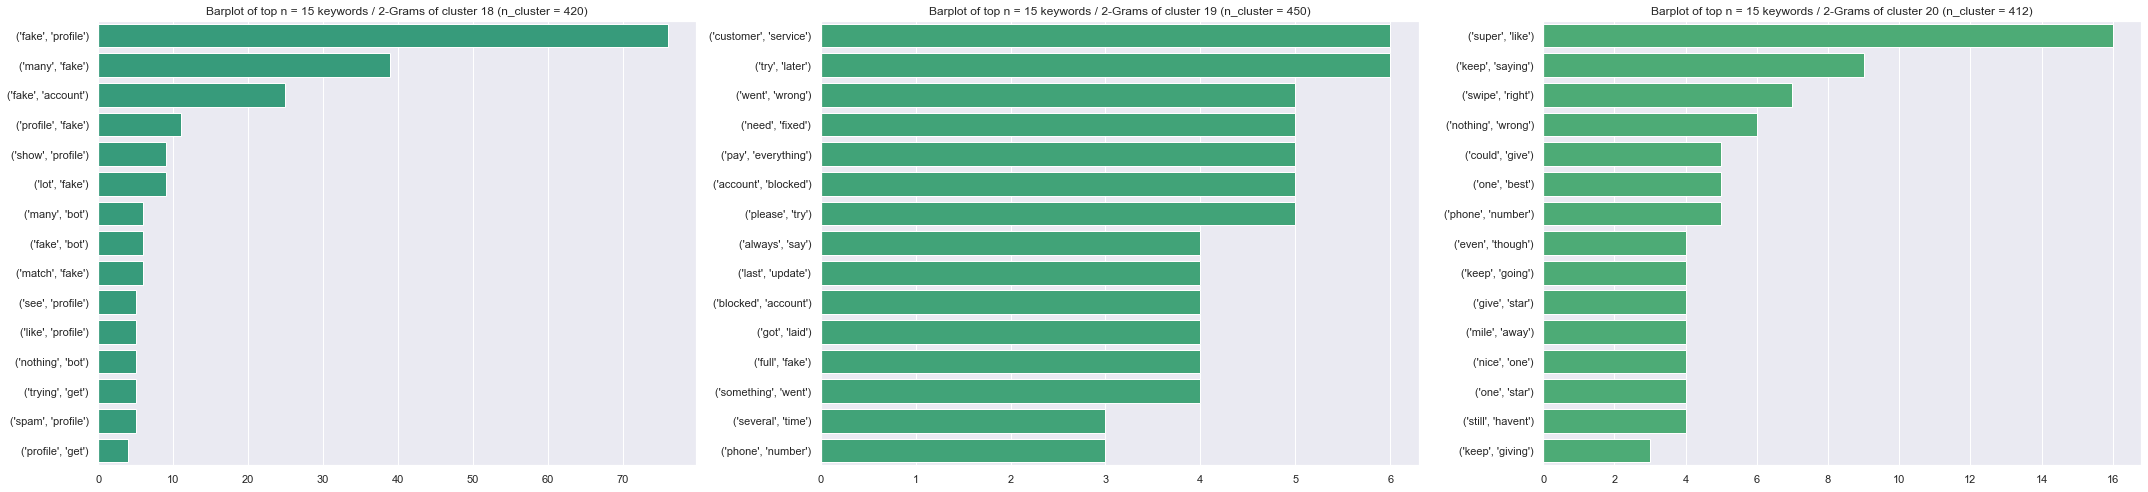

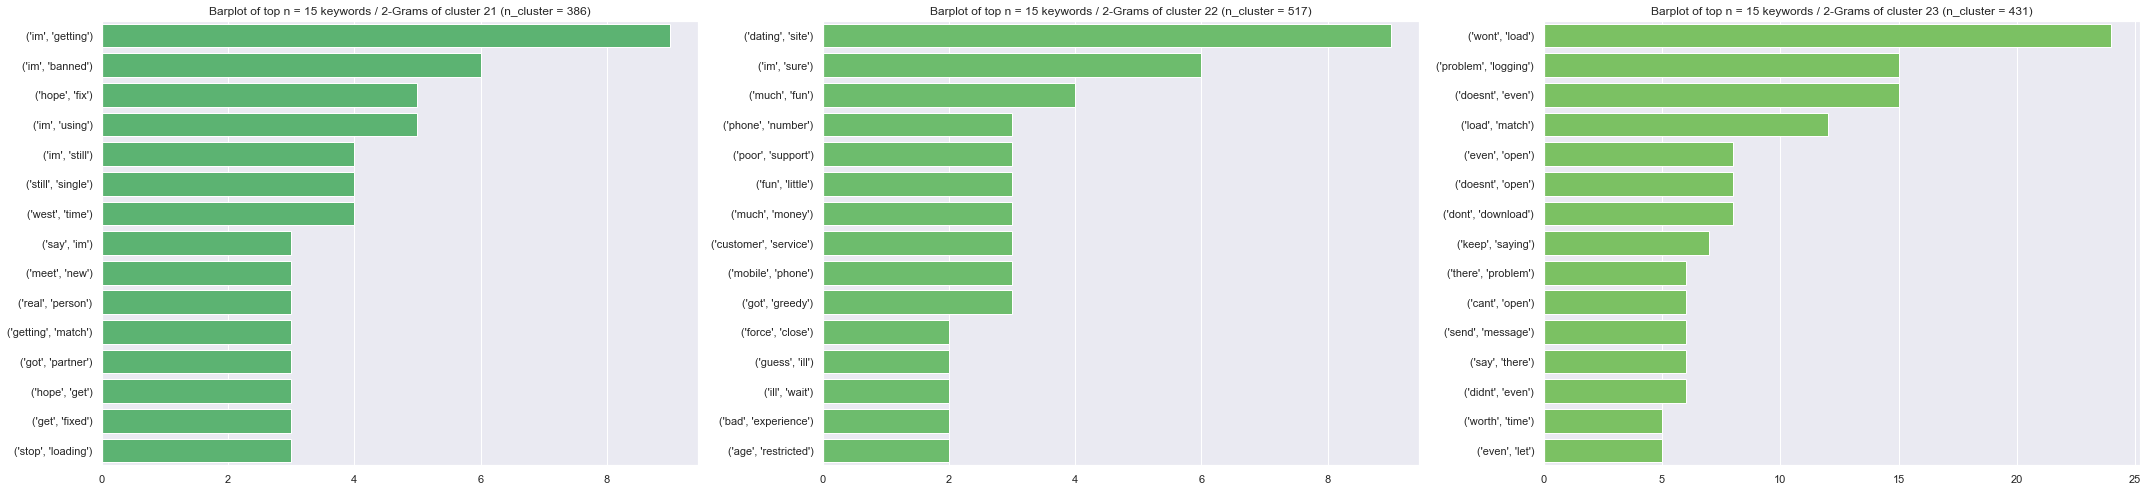

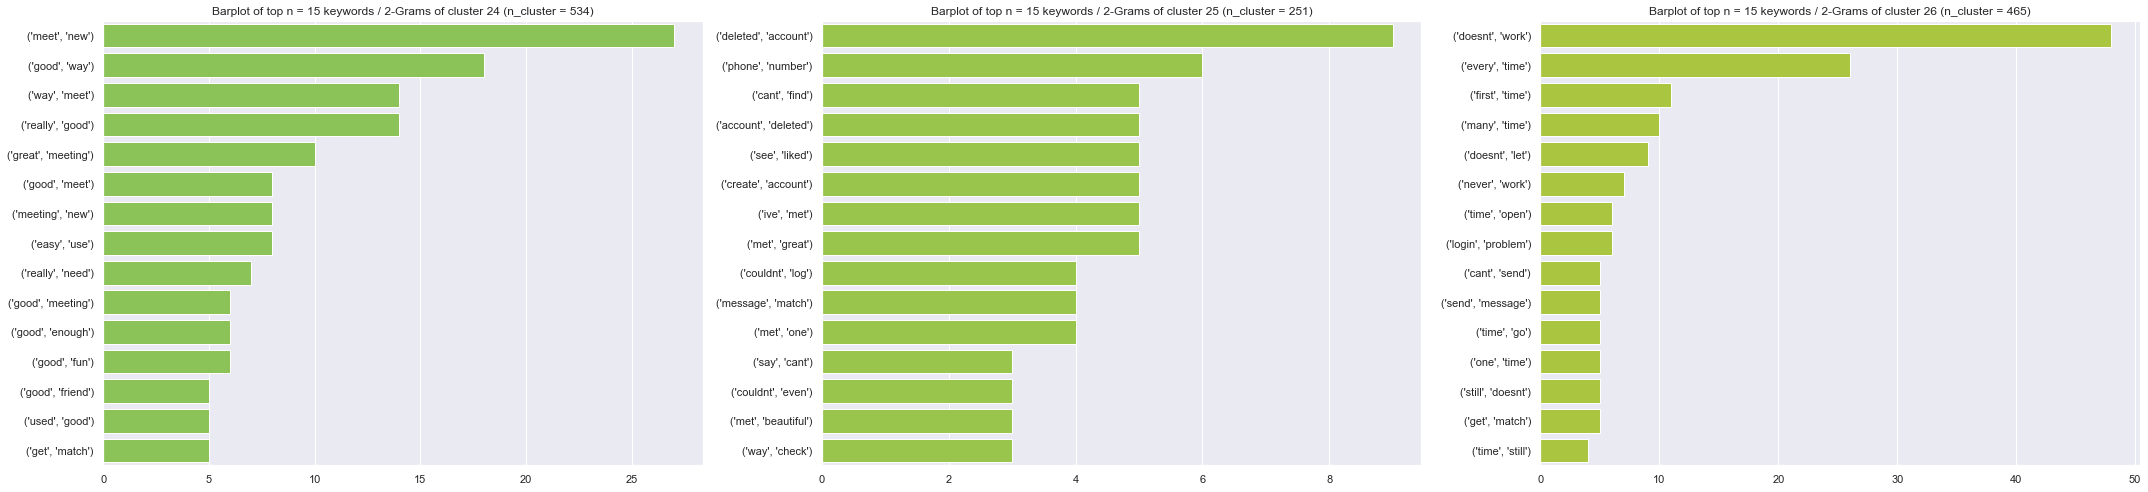

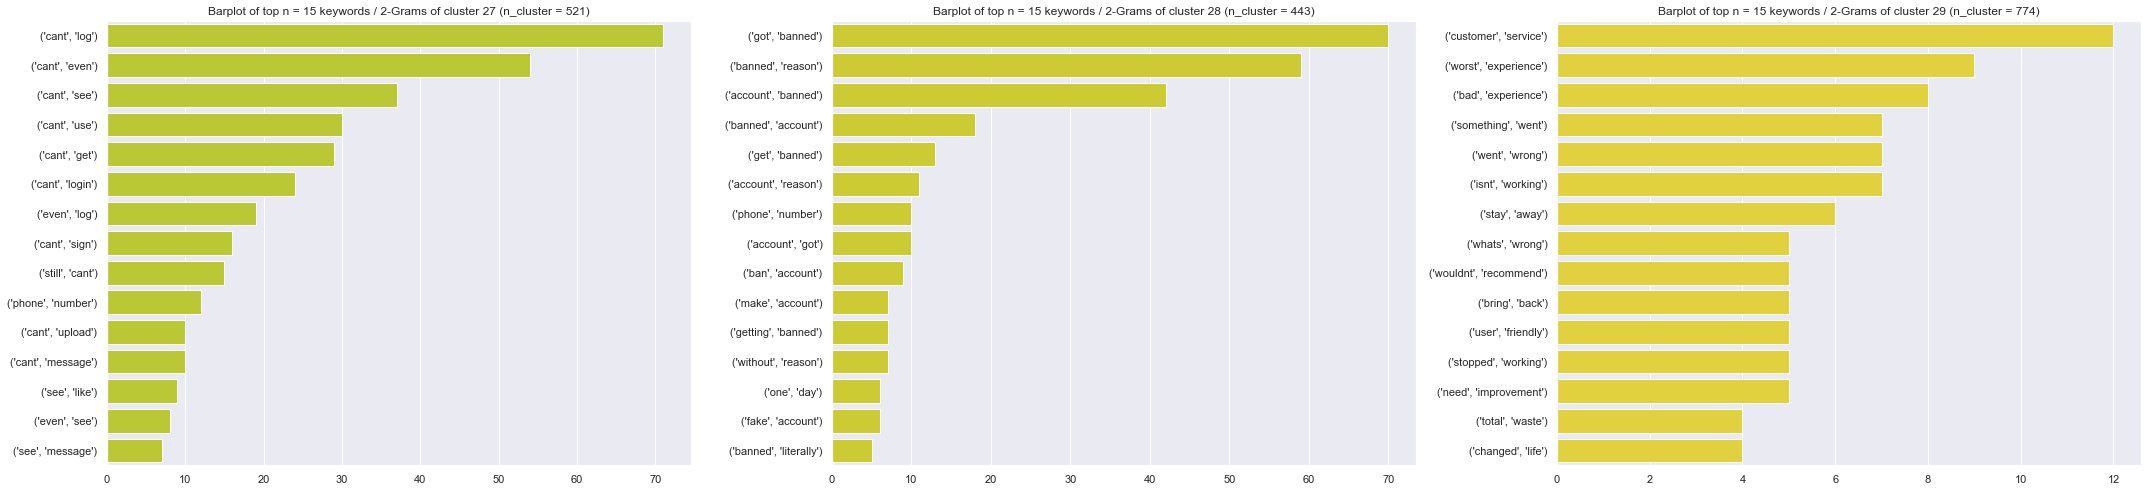

In [33]:
# Define Hyperparams
N_GRAMS = 2 # {1, 2, 3}
N_KEYWORDS = 15

mykeywordsanalyzer = MyKeywordsAnalyzer(X_transformed_df = X_transformed_df_TSNE, 
                                       n_clusters = N_CLUSTERS_TSNE, n_keywords = N_KEYWORDS, 
                                       verbose = False, n_grams = N_GRAMS,
                                       palette = viridis(N_CLUSTERS_TSNE))

# Plot keywords for all clusters
#mykeywordsanalyzer.plot_keywords_all_clusters()

# Plot keywords only for cluster c
#mykeywordsanalyzer.plot_keywords(c = 5)

# Plot keywords in grid
mykeywordsanalyzer.plot_keywords_grid(n_cols = 3)

# + Function: TFIDF Keywords of Clusters

We can give out keywords (onegrams, bigrams and trigrams) based on their tfidf score. This also contributes to understand why certain clusters were formed.

In [25]:
from custom_classes.D2V_MyTFIDFAnalyzer import MyTFIDFAnalyzer

# Define Hyperparams
TFIDF_N_OUTPUT = 30
TFIDF_N_GRAMS = (2, 2) # Must be a tuple in {(1,1), (1,2), (1,3), (2, 2), (2, 3), (3, 3)} -- (1, 2) e.g. means using onewords and bigrams simultaneously

# Instantiate Object of the Class
mytfidfanalyzer = MyTFIDFAnalyzer(X_transformed_df = X_transformed_df_TSNE, 
                                  n_clusters = N_CLUSTERS_TSNE, 
                                  target_column = TARGET_COLUMN, 
                                  max_docfreq = MAX_DOCFREQ, 
                                  stopwords = STOPWORDS_FINAL, 
                                  tfidf_n_output = TFIDF_N_OUTPUT, 
                                  tfidf_n_grams = TFIDF_N_GRAMS)

In [26]:
#mytfidfanalyzer.print_all_tfidf_keywords()
mytfidfanalyzer.print_tfidf_keywords_of_cluster_c(c = 0)

________________________________________________________________________________
Cluster c = 0 filtered matrix X has shape (515, 5)
Print top n = 30 keywords based on tfidf-score:

['best dating' 'way meet' 'great way' 'works great' 'simple easy'
 'good luck' 'worst dating' 'works fine' 'great fun' 'great easy'
 'meet new' 'easy way' 'great experience' 'easy get' 'meet many'
 'great meet' 'making new' 'new friends' 'best luck' 'otherwise great'
 'great dating' 'would great' 'great ever' 'great start' 'great works'
 'quick easy' 'new friend' 'used best' 'great get' 'great little']


# + Function: Doc Similarities

The **print_similar()** function expects an **input_doc**. The input_doc then gets tokenized and cleaned and then infered as a vector based on our doc2vec model. With this vector representation we can print all similiar docs that our model has already learned. The similiarity mean is the cosine similarity.

You can define the **input_doc** parameter as any arbitrary string (includes words and sentences).

In [27]:
# Take already instantiated object 'mydoc2vec' of class MyDoc2Vec and call print_similar()
input_doc_example_1 = "idrive system"
input_doc_example_2 = "reboot"
input_doc_example_3 = "press button and hold"
input_doc_example_4 = "spotify"
input_doc_example_5 = "Customer stated they removed Spotify in the vehicle and use Spotify in Apple CarPlay."

# Call print_similar()
mydoc2vec.print_similar(input_doc = "fake profile", 
                        n = 7, 
                        custom_stopwords = STOPWORDS_FINAL)

Tokens from input text: ['fake', 'profile']
Shape of text in vector representation: (200,)
________________________________________________________________________________
This app is fake.
['fake']
(Cosine Similarity: 80.33 % | doc_tag = 4876) 

It's all fake profiles
['fake', 'profile']
(Cosine Similarity: 77.2 % | doc_tag = 5554) 

Don't waste your time, fake profiles, scam artists, fake fake fake
['dont', 'waste', 'time', 'fake', 'profile', 'scam', 'artist', 'fake', 'fake', 'fake']
(Cosine Similarity: 71.08 % | doc_tag = 167) 

Now they have ads pop up as profiles.
['ad', 'pop', 'profile']
(Cosine Similarity: 70.45 % | doc_tag = 4420) 

Fake profiles
['fake', 'profile']
(Cosine Similarity: 69.69 % | doc_tag = 808) 

It's way better than badoo and it's not fake
['way', 'better', 'badoo', 'fake']
(Cosine Similarity: 67.23 % | doc_tag = 7818) 

99% of my "matches" are fake profiles.
['match', 'fake', 'profile']
(Cosine Similarity: 66.86 % | doc_tag = 11107) 



# + Function: Draw Subclusters

To draw subclusters we use again the **MyVisualizer** class and call the **draw_sub_clusters()** function.

The function expects:
- **c:int** The initial kmeans_cluster you want to further analyze, i.e. create subclusters
- **n_clusters:int** The number of subclusters you want to have (using AgglomerativeClustering)
- **blob_size:int** Size of the blobs (scatters)
- **drawDendro:bool** Whether you want to draw a dendrogram. A dendrogram helps you finding a good parameter choice for n_clusters by plotting the distance where all clusters get merged. Dendrogram has a run time of O(n^3), therefore set the value to False to significantly fasten the run time.
- **tfidf_keyword_list:list** List of all tfidf keywords; Helps identify which initial kmeans cluster you have choosen by printing information in the title

In [28]:
# myvisualizer_TSNE.draw_sub_clusters(c = 10,
#                                     n_clusters = 3,
#                                     blob_size = 7,
#                                     drawDendro = True, 
#                                     tfidf_keyword_list = mytfidfanalyzer.get_tfidf_keywords_list())

# BETA: OpenAI Text Summarization

In [29]:
# %%capture
# pip install --upgrade openai

In [30]:
# import openai

# def try_openai_summarization():
#     openai.api_key = ""

#     # import openai

#     # Reading a review which belong to each group.
#     rev_per_cluster = 30

#     for i in range(N_CLUSTERS_TSNE):
#         print(f"Cluster {i} Theme:", end=" ")

#         reviews = "\n".join(master[master.kmeans_cluster == i].sentence.sample(rev_per_cluster, random_state=42).values)
#         response = openai.Completion.create(
#             engine="davinci-instruct-beta-v3",
#             prompt=f"What do the following customer reviews have in common?\n\nCustomer reviews:\n\"\"\"\n{reviews}\n\"\"\"\n\nTheme:",
#             temperature=0.5,
#             max_tokens=120,
#             top_p=1,
#             frequency_penalty=1,
#             presence_penalty=1
#         )
#         print(response["choices"][0]["text"].replace('\n',''))

#         sample_cluster_rows = master[master.kmeans_cluster == i].sample(rev_per_cluster, random_state=42) 
#         for j in range(rev_per_cluster):
#     #         print(sample_cluster_rows.answer_nps.values[j], end=", ")
#     #         print(sample_cluster_rows.comment_sentiment.values[j], end=":   ")
#             print(sample_cluster_rows.sentence.str[:70].values[j])

#         print("-" * 100)
 
# # Simply uncomment this to call function
# #try_openai_summarization()